In [1]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
pn.extension()

from ratmoseq_extract.flip import FlipClassifierWidget, create_training_dataset, train_classifier, save_classifier

In [2]:
data_dir = '/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/data/14weeks'
frames_name = 'frames'

In [3]:
widget = FlipClassifierWidget(data_dir, frames_name)

In [4]:
widget.show()

Row
    [0] Column(width=325)
        [0] Select(name='Session', options=['session_20240731092547/r...], value='session_20240731092547/re...)
        [1] IntSlider(end=14391, name='Current Frame')
        [2] Button(button_type='primary', name='Start Range')
        [3] Row
            [0] Button(button_type='primary', name='Backward', width=142)
            [1] Button(button_type='primary', name='Forward', width=142)
        [4] Markdown(str, visible=False)
        [5] Row
            [0] Button(button_type='success', name='Facing Left', visible=False, width=140)
            [1] Button(button_type='success', name='Facing Right', visible=False, width=140)
        [6] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] MultiSelect(name='Selected Ranges')
            [3] Button(button_type='danger', name='Delete Selection')
    [1] HoloViews(DynamicMap, sizing_mode='fixed')

In [5]:
# widget.save_frame_ranges()

In [6]:
path = widget.data_path.parent / "flip-training-frame-ranges.p"

In [7]:
widget.data_path.parent / "flip-training-frame-ranges.p"

PosixPath('/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/data/flip-training-frame-ranges.p')

In [8]:
# training_set = create_training_dataset(path)

In [9]:
training_set = '/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/data/training_data.npz'

In [10]:
# ls /n/groups/datta/jlove/data/rat_seq/rat_seq_paper/data/

In [11]:
data = np.load(training_set)
frames = data["frames"]
flipped = data["flipped"]

In [12]:
flipped.shape, frames.shape

((36378,), (36378, 256, 256))

In [13]:
from sklearn.decomposition import PCA
def flatten(array: np.ndarray) -> np.ndarray:
    return array.reshape(len(array), -1)

In [14]:
# pca = PCA(n_components=20)

In [15]:
# pca.fit(flatten(frames[-len(frames) // 3 :]))

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [17]:
from ratmoseq_extract.flip import batch_apply_pca, flatten

In [18]:
# def batch_apply_pca(frames: np.ndarray, pca, batch_size: int = 1000) -> np.ndarray:
#     output = []
#     if len(frames) < batch_size:
#         return pca.transform(flatten(frames)).astype(np.float32)

#     for arr in np.array_split(frames, len(frames) // batch_size):
#         output.append(pca.transform(flatten(arr)).astype(np.float32))
#     return np.concatenate(output, axis=0).astype(np.float32)

In [19]:
# classifier = 'RF'
# batch_size=1000

# pipeline = make_pipeline(
#     FunctionTransformer(batch_apply_pca, kw_args={'pca':pca}, validate=False),
#     StandardScaler(),
#     RandomForestClassifier(n_estimators=150)
# )

# pipeline = make_pipeline(
#     FunctionTransformer(flatten, validate=False),
#     PCA(n_components=20), 
#     StandardScaler(),
#     RandomForestClassifier(n_estimators=150)
# )
from sklearn.base import BaseEstimator, TransformerMixin
# Custom transformer to reshape 3D data to 2D in batches
class BatchPCA(BaseEstimator, TransformerMixin):
    def __init__(self, pca, batch_size=1000):
        self.pca = pca
        self.batch_size = batch_size

    def fit(self, X, y=None):
        # Flatten and fit PCA on the data in batches
        n_samples, _, _ = X.shape
        self.pca.fit(flatten(X[:-n_samples // 3]))  # Fit PCA on the flattened data
        return self

    def transform(self, X):
        # Transform data in batches
        n_samples, _, _ = X.shape
        output = []

        # Process in batches to avoid memory overload
        for i in range(0, n_samples, self.batch_size):
            transformed_batch = self.pca.transform(flatten(X[i:i + self.batch_size]))
            output.append(transformed_batch)

        return np.concatenate(output, axis=0)

# Define PCA and other pipeline components
pca = PCA(n_components=20)
batch_size = 100

pipeline = make_pipeline(
    BatchPCA(pca, batch_size=batch_size),  # Apply PCA in batches
    StandardScaler(),
    RandomForestClassifier(n_estimators=150)
)

In [20]:
# accuracy = cross_val_score(
#     pipeline, frames, flipped, cv=KFold(n_splits=4, shuffle=True, random_state=0), error_score='raise'
# )

In [21]:
# accuracy

In [22]:
pipeline.fit(frames, flipped)

Pipeline(steps=[('batchpca',
                 BatchPCA(batch_size=100, pca=PCA(n_components=20))),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=150))])

In [23]:
save_classifier(pipeline, widget.data_path.parent / "14weeks-flip.p")

Classifier saved to /n/groups/datta/jlove/data/rat_seq/rat_seq_paper/data/14weeks-flip.p


In [25]:
import joblib

In [26]:
clf = joblib.load(widget.data_path.parent / "14weeks-flip.p")

In [27]:
clf

Pipeline(steps=[('batchpca',
                 BatchPCA(batch_size=100, pca=PCA(n_components=20))),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=150))])

In [28]:
preds = clf.predict(frames)

In [ ]:
clf = train_classifier(training_set)

In [22]:
-len(frames) // 3 

-12126

In [24]:
frames.shape[0]-len(frames) // 3 

24252

In [9]:
clf = train_classifier(training_set)

Fitting PCA
Running cross-validation


ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py", line 260, in transform
    out = self._transform(X, func=self.func, kw_args=self.kw_args)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py", line 387, in _transform
    return func(X, **(kw_args if kw_args else {}))
  File "/n/groups/datta/jlove/data/ratmoseq_extract/ratmoseq_extract/flip.py", line 100, in batch_apply_pca
    output.append(pca.transform(flatten(arr)).astype(np.float32))
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/jal5475/.miniconda/envs/ratmoseq_extract/lib/python3.10/site-packages/sklearn/decomposition/_base.py", line 134, in transform
    xp, _ = get_namespace(X, self.components_, self.explained_variance_)
AttributeError: 'PCA' object has no attribute 'components_'. Did you mean: 'n_components'?


In [ ]:
save_classifier(clf, widget.data_path.parent / "14weeks-flip.p")

In [3]:
from pathlib import Path

In [4]:
files = Path(data_dir).glob('**/results_00.h5')

In [5]:
files = list(files)

In [7]:
import h5py

(14792, 576, 640)


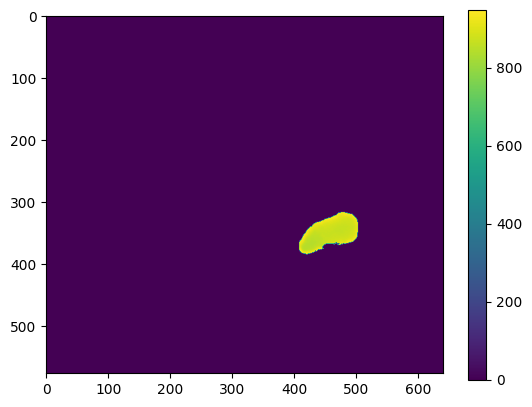

In [11]:
with h5py.File(files[0], 'r') as f:
    # print(f.keys())
    print(f['raw_frames'].shape)
    plt.imshow(f['raw_frames'][0])
    plt.colorbar()